Dataset Link: [Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci)

*Attribute Information*
- **cp**: chest pain type (4 values) 
- **tresttbps**: resting blood pressure 
- **chol**: serum cholestoral in mg/dl 
- **fbs**: fasting blood sugar > 120 mg/dl
- **restecg**: resting electrocardiographic results (values 0,1,2)
- **thalach**: maximum heart rate achieved 
- **exang**: exercise induced angina 
- **oldpeak**: ST depression induced by exercise relative to rest 
- **slope**: the slope of the peak exercise ST segment 
- **ca**: number of major vessels (0-3) colored by flourosopy 
- **thal**: 3 = normal; 6 = fixed defect; 7 = reversable defect

![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)

### Initial Steps

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("../input"))

['heart.csv']


In [129]:
# Remove Warnings in JupyterNotebook (I hate those warnings!)
import warnings
warnings.simplefilter('ignore')

In [130]:
df = pd.read_csv('../input/heart.csv')
df.sample(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
176,60,1,0,117,230,1,1,160,1,1.4,2,2,3,0
143,67,0,0,106,223,0,1,142,0,0.3,2,2,2,1


In [131]:
# Let's change the column names based on information on dataset description. It would be much more understandable.
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target' ]

In [132]:
df.shape

(303, 14)

In [133]:
# There's no Null value inside the data frame
df.isnull().sum().value_counts()

0    14
dtype: int64

![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)

### Data Visualization

Most of the times, I would like to check the **correlation** between all the variables to have an initial thougth of possible relation between them and heatmap is the best way for that.

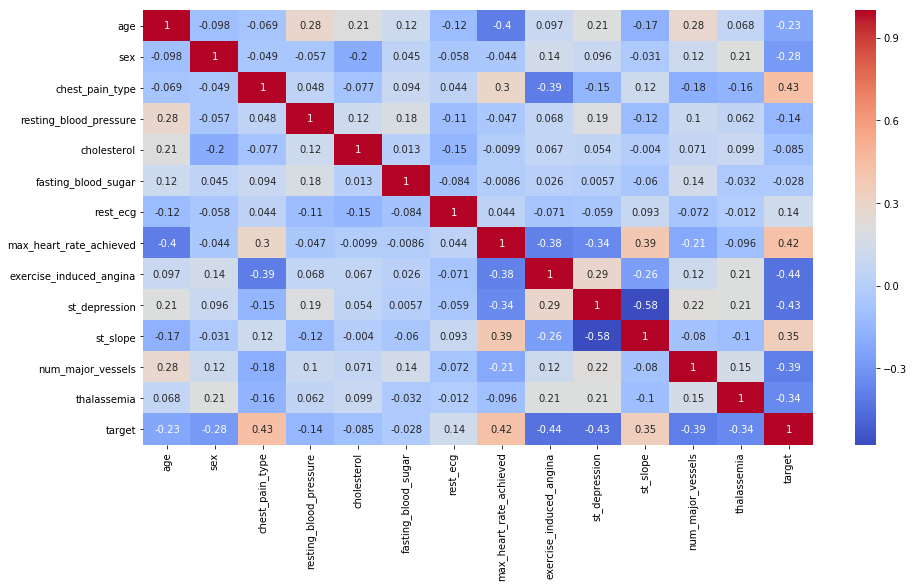

In [134]:
# Check the Correlation between variables
df_corr = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(df_corr, cmap='coolwarm', annot=True)

Before start our analysis, we should visit Google and search for hear disease causes and the variables we have in our data set. Based on our Google-study and above heatmap, we can continue to analyze a few of these variables, like set_depression with a noticable correlation with target. 

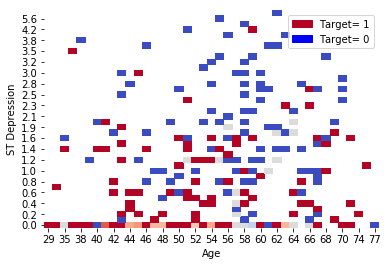

In [135]:
# Turn our data into matrix form
dfmat = df.pivot_table(columns='age', index='st_depression', values='target')

# Use heatmap to draw the chart. I also used invert_yaxis() to change the order of y_axis,
# you can delete this part to see the difference.
sns.heatmap(dfmat, cmap='coolwarm', cbar=False).invert_yaxis()

# Let's have more clever chart! illustrating labels and legend
plt.ylabel('ST Depression')
plt.xlabel('Age')

from matplotlib.patches import Patch
red_patch = Patch(color='#B40426', label='Target= 1')
blue_patch = Patch(color='blue', label='Target= 0')
plt.legend(handles=[red_patch, blue_patch])

From above chart(heatmap), we can see there's no meaningful relation between ST Depression and Age, but as soon as ST Depression gets higher than 2 (approximately), the Target color tends to turn into blue/0 which means higher ST Depression, lower risk of hear disease.

There's another way to check this possibility from JointPlot:

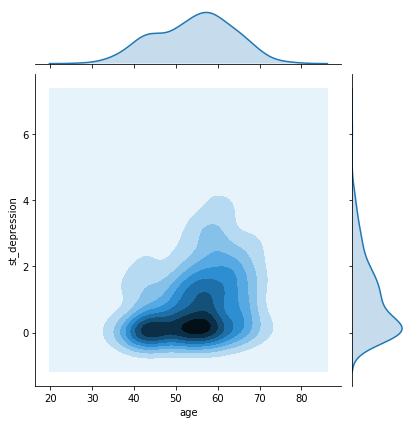

In [136]:
sns.jointplot(x=df.age, y=df.st_depression, data=df, kind='kde')

The next plot is a linear relation between **age** & **max_hear_rate_achieved**. It shows that the max_hear_rate decreased slightly as the age goes high. But the deviation is high.

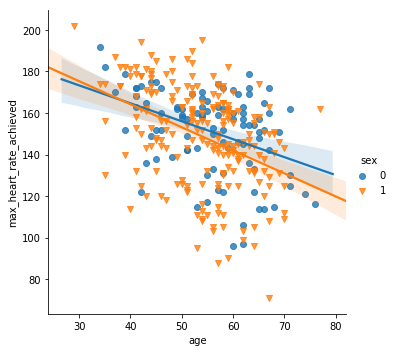

In [137]:
sns.lmplot(data=df, x='age', y='max_heart_rate_achieved', hue='sex', markers=['o','v'])

FacetGrid allows us to see the difference between **male** and **female** at different **types** of chest pain (from 0 to 3)

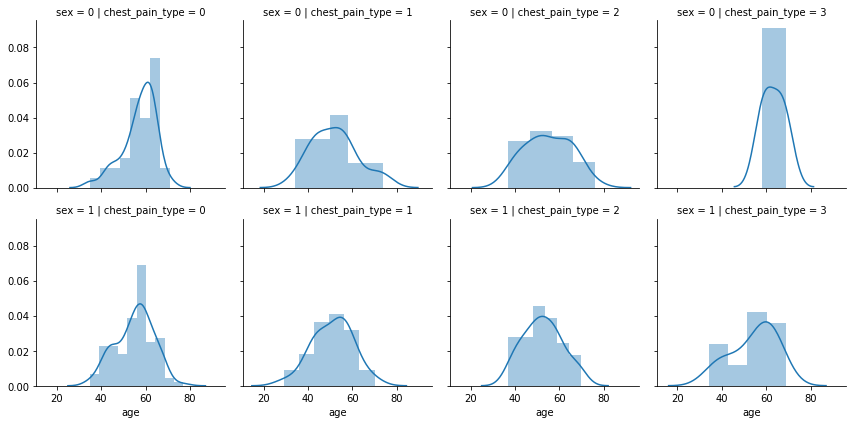

In [138]:
FG = sns.FacetGrid(data=df, row='sex', col='chest_pain_type')
FG.map(sns.distplot, 'age')

In [139]:
i = df.groupby(['chest_pain_type'])['sex']
i
#sns.jointplot(x=df.age, y=df.chest_pain_type, data=df, kind='kde')

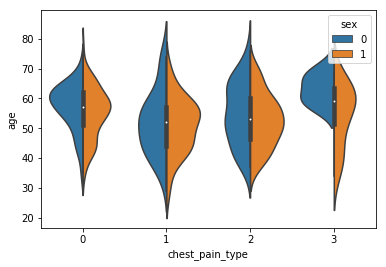

In [140]:
sns.violinplot(data=df, x='chest_pain_type', y='age', hue='sex', split=True)

![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)

### Machine Learning:
**Linear Regression**

In [141]:
df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'num_major_vessels', 'thalassemia', 'target'],
      dtype='object')

Like any other regression model, we need to **split** our data frame into **train** and **test** using scikit-learn

In [142]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [143]:
from sklearn.linear_model import LinearRegression

# create an instance from LinearRegression name "lm" and fit the model
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**Evaluate Model**

In [144]:
coeff_df = pd.DataFrame((lm.coef_)*100, X.columns, columns=['Coefficient (percentage %)'])
coeff_df

,Coefficient (percentage %)
age,0.088216
sex,-17.135289
chest_pain_type,15.474457
resting_blood_pressure,-0.296914
cholesterol,-0.044848
fasting_blood_sugar,7.615984
rest_ecg,6.685205
max_heart_rate_achieved,0.455400
exercise_induced_angina,-10.422606
st_depression,-3.508077


So it means:
*  Holding all features fixed, a *1 unit increase* in **Chest_Pain_Type** (CP) is associated with an increase of 7.7% chance of having heart disease.
*  Holding all features fixed, a *1 unit increase* in **ST Slope** is associated with an increase of 8% chance of having heart disease.
*  And because in sex category male are 1 and female are 0, then holding all features fixed, the chance of having heart disease for female are higher than male

**Predict Model**

There are four ways to check if the predictions are right or wrong:
1. TN / True Negative: case was negative and predicted negative
2. TP / True Positive: case was positive and predicted positive
3. FN / False Negative: case was positive but predicted negative
4. FP / False Positive: case was negative but predicted positive

In evaluation of our model, when we use Classification_Report, we need to know the meaning of each one of these parameters:

**Precision** - What percent of your predictions were correct?
- Precision: Accuracy of positive predictions

*Precision = TP/(TP + FP)*


**Recall** – What percent of the positive cases did you catch?
- Recall: Fraction of positives that were correctly identified

*Recall = TP/(TP+FN)*

**F1 score** – What percent of positive predictions were correct?
- The F1 score is a weighted harmonic mean of precision and recall
- As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

*F1 Score = 2*(Recall * Precision) / (Recall + Precision)*

In [145]:
prediction = lm.predict(X_test)

In [146]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_test, prediction.round()))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82        53
           1       0.85      0.88      0.87        69

   micro avg       0.84      0.84      0.84       122
   macro avg       0.84      0.84      0.84       122
weighted avg       0.84      0.84      0.84       122



In [147]:
print('The Accuarcy Score of our Model would be: ', accuracy_score(y_test, prediction.round())*100, '%')

The Accuarcy Score of our Model would be:  84.42622950819673 %


![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)

### Machine Learning:
**SVM Model**
   (Support Vector Machines)

In [148]:
from sklearn.svm import SVC

# create an instance from SCV and fit the model
SVM_model = SVC()
SVM_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [149]:
prediction2= SVM_model.predict(X_test)

In [150]:
print(confusion_matrix(y_test, prediction2))
print(classification_report(y_test,prediction2))

[[ 2 51]
 [ 0 69]]
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        53
           1       0.57      1.00      0.73        69

   micro avg       0.58      0.58      0.58       122
   macro avg       0.79      0.52      0.40       122
weighted avg       0.76      0.58      0.44       122



Notice that we are classifying everything into a single class!
This means our model needs to have it parameters adjusted (*it may also help to normalize the data*)

We can search for parameters using a **GridSearch**!

**Gridsearch**

In [151]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [152]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.5245901639344263, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.5333333333333333, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.5333333333333333, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.5245901639344263, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.5333333333333333, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.5333333333333333, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ............................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, gamma=0.001, kernel=rbf, score=0.5666666666666667, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.5573770491803278, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.7333333333333333, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.6666666666666666, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.5245901639344263, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.5333333333333333, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.5333333333333333, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf ...............

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

Now, we can inspect the *best parameters* found by **GridSearchCV** in the **best_params_** attribute, and the *best estimator* in the **best_estimator_** attribute:

In [153]:
grid.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

In [154]:
grid.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Now it's time to re-run predictions on this grid object

In [155]:
grid_predictions = grid.predict(X_test)

In [156]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[36 17]
 [12 57]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        53
           1       0.77      0.83      0.80        69

   micro avg       0.76      0.76      0.76       122
   macro avg       0.76      0.75      0.76       122
weighted avg       0.76      0.76      0.76       122



In [157]:
print('The Accuarcy Score of our Model would be: ', accuracy_score(y_test, grid_predictions.round())*100, '%')

The Accuarcy Score of our Model would be:  76.22950819672131 %


![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)

So, we examined two ML model: Linear Regression & SVM

Here is the accuray of each one of them:

Text(0, 0.5, 'Accuracy Score (%)')

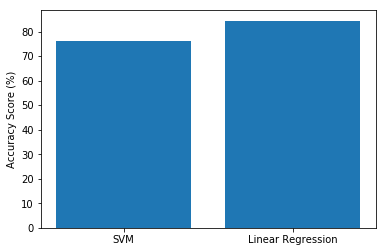

In [158]:
y = (accuracy_score(y_test, grid_predictions.round())*100, accuracy_score(y_test, prediction.round())*100)
x = ['SVM', 'Linear Regression']
plt.bar(x, y)
plt.ylabel('Accuracy Score (%)')

![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)

**Further Study**

### SHAP Values ###
Check this Kernel in Kaggle for full description: [LINK](https://www.kaggle.com/dansbecker/shap-values)

**SHAP Values** break down a prediction to show the impact of each feature.

Where could you use this?
* A model says a bank shouldn't loan someone money
* A healthcare provider wants to identify what factors are driving each patient's risk of some disease

**SHAP values** interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

> Feature values causing **increased predictions** are in **pink**, and their visual size shows the magnitude of the feature's effect.

> Feature values **decreasing the prediction** are in **blue**.

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

data = df
my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [160]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
my_model.predict_proba(data_for_prediction_array)

array([[0.9, 0.1]])

So it means that the patient is 70% likely to have heart disease (target equal to 1)

In [161]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [162]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Here is the Summary Plot:

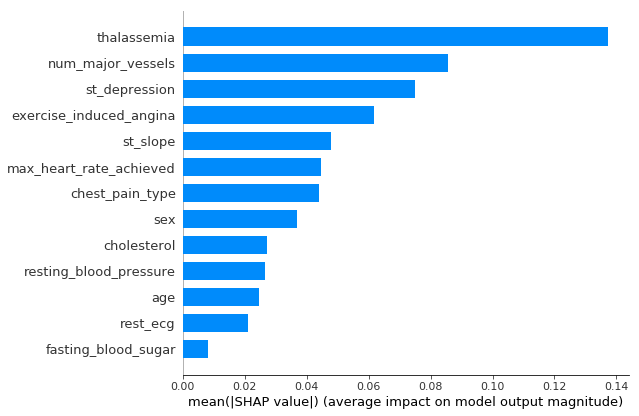

In [164]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

![](https://ui-ex.com/images/transparent-dividers-horizontal-line-6.png)